# Source Code 1.1)

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

### Load Data

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

- 데이터를 빠르게 로드할 수 있도록 하는 설정 변수입니다.

In [3]:
IMAGE_SIZE = [180, 180]

ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


- 이미지 사이즈는 (180, 180)
- 배치 사이즈는 16
- EPOCH 는 25

In [4]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


- train 은 5216 개
- test 는 624 개
- validation 은 16 개

- validation data 의 개수가 부족하기 때문에 다시 나누어주도록 하겠습니다.

In [5]:
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

train_size = math.floor(len(filenames) * 0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


- filenames 에 train 과 val data 를 모두 담습니다.
- 이후 무작위로 데이터를 shuffling 한 후, 8:2 의 비율로 나누어줍니다.
- train 은 4185 개
- validation 은 1047 개

In [6]:
print(train_filenames[0])
print(val_filenames[10])

/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person394_bacteria_1792.jpeg


- 라벨의 비율을 확인하기 위해서 NORMAL 과 PNEUMONIA 의 개수를 확인하여야 합니다.
- 라벨은 파일 경로의 폴더 이름으로 구별해낼 수 있습니다.

In [7]:
COUNT_NORMAL = len([filename for filename in train_filenames if 'NORMAL' in filename])
print("Normal images count in training set: {}".format(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if 'PNEUMONIA' in filename])
print("Pneumonia images count in training set: {}".format(COUNT_PNEUMONIA))

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


- 폐렴 양성이미지의 수가 정상이미지의 수보다 3배 많습니다.
- 이렇게 불균형한 데이터는 weight balancing 으로 모델 학습 시 조정해주어야 합니다.

In [8]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

- training set 과 validation set 에 대해 tf.data 인스턴스로 만들어주었습니다.
- 이는 학습 시 mini-batch 를 활용하기 위함입니다.

In [9]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: {}".format(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: {}".format(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


- 현재 이미지에는 라벨 데이터가 없습니다.
- 따라서, 파일 경로를 활용하여 라벨 데이터를 만들어주도록 하겠습니다.

### Util Function

In [10]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"

- 파일 경로를 활용하여 라벨 데이터를 만들어주는 함수를 정의하였습니다.
- 양성이라면 True, 음성이라면 False 를 반환합니다.

In [11]:
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMAGE_SIZE)
    return img

- 또한, 이미지의 크기가 제각각이기 때문에, 앞서 설정한 IMAGE_SIZE 로 이미지의 크기를 변환하는 함수를 정의하였습니다.

In [12]:
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

- 위 함수는 get_label 과 decode_img 를 활용하여 파일 경로를 인자로 받아 라벨을 생성하고 이미지의 크기를 조정합니다.

In [13]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

- 인자로 받은 data set 을 무작위로 shuffling 합니다.
- repeat() 을 통해 여러 번 data set 을 사용할 수 있게 합니다.
- batch() 를 통해 BATCH_SIZE 만큼의 batch 를 설정합니다.
- prefetch() 는 GPU 와 CPU 의 유휴 상태를 줄여줍니다.

In [14]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

- show_batch() 는 입력된 배치의 데이터 별로 이미지와 라벨을 시각화하는 함수입니다.

### Data Preprocessing

In [15]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

- process_path 함수로 training set 과 validation set 을 전처리해주었습니다.
- 이제 이미지의 크기는 IMAGE_SIZE 로 통일되었고, 각 이미지에는 라벨이 붙어있습니다.

In [16]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


- 하나의 데이터를 가져와 이미지의 크기와 라벨을 확인해보았습니다.

In [17]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


- testing set 에 대해서도 동일한 작업을 진행해주었습니다.
- testing set 에 batch 를 설정해주었습니다.

In [18]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

- 앞서 정의한 prepare_for_training() 을 이용하여 training set 과 validation set 을 무작위로 shuffling 하고 batch 까지 설정해주었습니다.

### Data Visualization

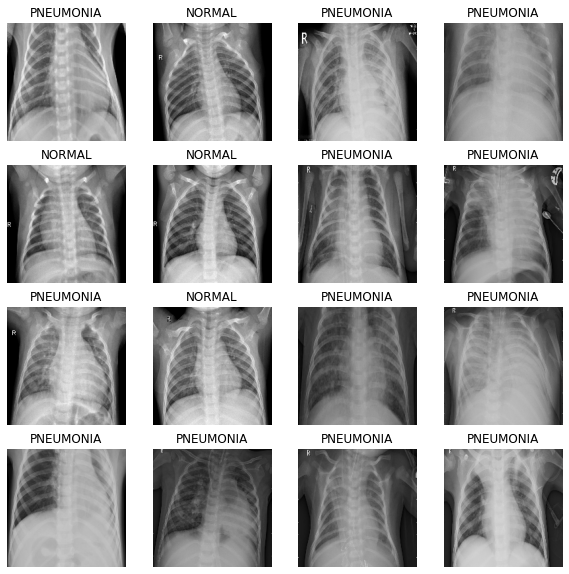

In [19]:
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch, label_batch)

- 앞서 정의한 show_batch() 를 활용하여 배치 내 데이터에 대해 시각화해보았습니다.

### Modeling

In [20]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

- Convolution Block 을 생성하는 함수입니다.
- filter 의 크기를 인자로 받습니다.
- BatchNormalization 을 수행합니다.

In [21]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

- Dense Block 을 생성하는 함수입니다.
- 뉴런의 개수와 dropout 비율을 인자로 받습니다.
- BatchNormalization 을 수행하고, dropout 또한 수행합니다.

In [22]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

- 앞서 정의한 convolution block 과 dense block 을 포함하여 Model 을 생성하는 함수입니다.

### Weight Balancing

- 본격적인 모델링을 시작하기 전에 해결해야할 문제가 있습니다.
- training set 에서 폐렴 이미지가 정상 이미지보다 약 3 배 가량 많았던 문제입니다.
- weight balancing 기법을 활용하여 imbalance 한 데이터에 대해 처리해주겠습니다.

In [23]:
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


- 개수가 적었던 정상 이미지의 weight 이 높게 설정되었습니다.

### Training

In [24]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

- 이미지의 라벨은 True 와 False 로, 이진 분류 문제입니다.
- 따라서, binary crossentropy 를 사용합니다.
- 양성과 음성을 맞추어 낼 때의 중요도가 다르기 떄문에 accuracy 이외에 precision 과 recall metrics 를 활용하여야 합니다.

In [25]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 86s 190ms/step - loss: 0.4696 - accuracy: 0.7574 - precision: 0.9309 - recall: 0.7280 - val_loss: 0.5940 - val_accuracy: 0.7375 - val_precision: 0.7375 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 187ms/step - loss: 0.2444 - accuracy: 0.9045 - precision: 0.9741 - recall: 0.8953 - val_loss: 1.0240 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 189ms/step - loss: 0.2018 - accuracy: 0.9229 - precision: 0.9767 - recall: 0.9182 - val_loss: 0.2833 - val_accuracy: 0.8721 - val_precision: 0.8519 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 50s 191ms/step - loss: 0.1797 - accuracy: 0.9313 - precision: 0.9780 - recall: 0.9285 - val_loss: 0.2658 - val_accuracy: 0.9106 - val_precision: 0.9985 - val_recall: 0.8796
Epoch 5/25
261/261 [==============================] - 51s 197ms/step - loss: 0.1693 - accura

- GPU 를 선택하여 모델을 훈련시킵니다.

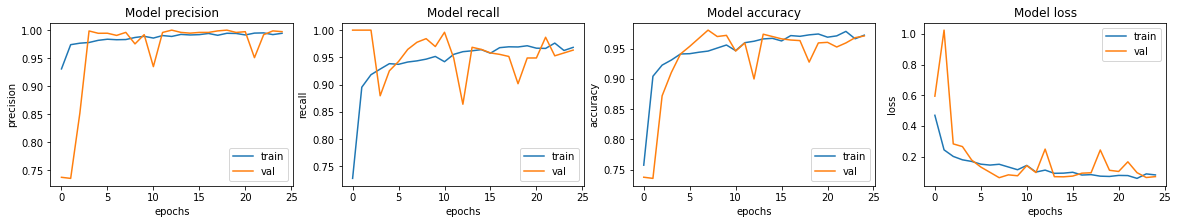

In [26]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

- 훈련된 모델의 결과를 시각화하였습니다.
- EPOCH 가 진행될수록, train data 와 validation data 간 metrics 의 그래프가 유사하게 진행되고 있습니다.
- batch normalization 과 dropout 의 사용으로 과적합이 발생하지 않았습니다.
- accuracy 는 증가하고 있으며, loss 도 감소하는 양상을 보이고 있습니다.

### Evaluate

In [27]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 107ms/step - loss: 0.8299 - accuracy: 0.8413 - precision: 0.8063 - recall: 0.9821
Loss: 0.8298662900924683,
Accuracy: 0.8413461446762085,
Precision: 0.8063157796859741,
Recall: 0.9820512533187866


- testing data 에 대해 예측하여 모델의 성능을 평가해보겠습니다.
- Accuracy 는 0.84, Precision 은 0.80, Recall 은 0.98 의 성능이 도출되었습니다.
- 폐렴 진단과 같은 문제에서는 Recall 이 더 중요한 지표입니다.
- 실제 폐렴 환자를 음성으로 오진하는 경우를 줄여나가는 것이 실제 음성 환자를 폐렴으로 오진하는 경우보다 중요하기 때문입니다.

# Source Code 1.2)

- 1.1) 에서는 dropout 과 batch normalization 을 함께 사용하였습니다.
- 이번에는 batch normalization 만을 사용하여 모델을 학습시켜보도록 하겠습니다.

### Load Data

In [20]:
print(train_ds)
print(val_ds)
print(test_ds)

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>
<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>
<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>


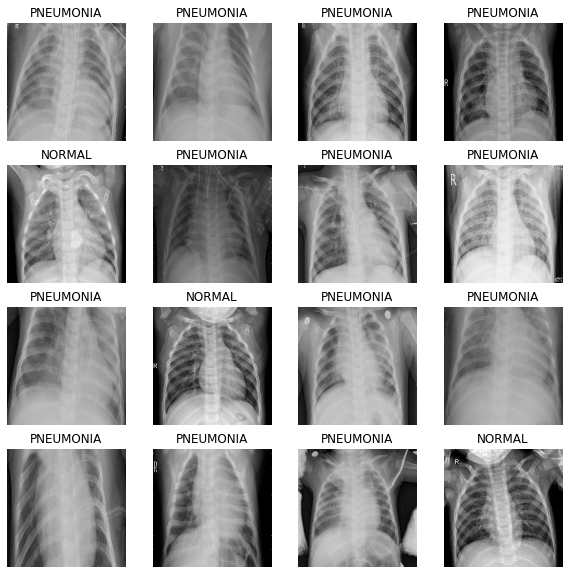

In [21]:
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch, label_batch)

### Modeling

In [22]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [23]:
def dense_block(units):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
    ])
    
    return block

In [24]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        
        conv_block(256),
        
        tf.keras.layers.Flatten(),
        dense_block(512),
        dense_block(128),
        dense_block(64),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

- 모델에서 dropout 을 모두 삭제하고 batch normalization 만을 사용하도록 수정했습니다.

### Weight Balancing

In [25]:
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


### Training

In [26]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [27]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 76s 190ms/step - loss: 0.2327 - accuracy: 0.9112 - precision: 0.9776 - recall: 0.9011 - val_loss: 0.6897 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 188ms/step - loss: 0.1524 - accuracy: 0.9404 - precision: 0.9824 - recall: 0.9366 - val_loss: 2.0302 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 189ms/step - loss: 0.1215 - accuracy: 0.9523 - precision: 0.9869 - recall: 0.9485 - val_loss: 0.1710 - val_accuracy: 0.9433 - val_precision: 0.9972 - val_recall: 0.9255
Epoch 4/25
261/261 [==============================] - 50s 190ms/step - loss: 0.1170 - accuracy: 0.9559 - precision: 0.9860 - recall: 0.9543 - val_loss: 0.1601 - val_accuracy: 0.9346 - val_precision: 0.9204 - val_recall: 0.9974
Epoch 5/25
261/261 [==============================] - 51s 196ms/step - loss: 0.0943 - accura

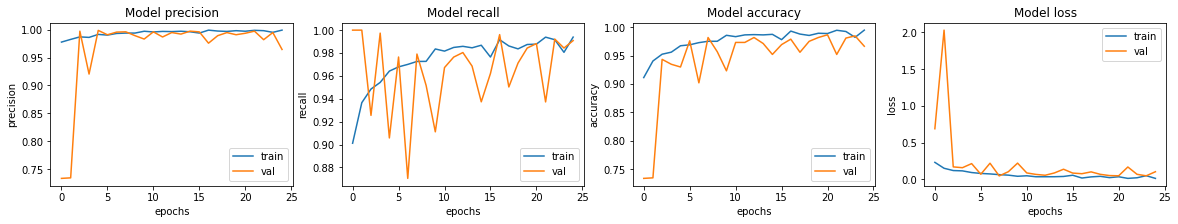

In [28]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

- accuracy 는 증가하고 loss 는 감소하는 모습을 확인할 수 있습니다.
- 다만, Recall 의 경우 불안정한 상승 양상을 보이고 있습니다.

### Evaluate

In [29]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 103ms/step - loss: 1.7303 - accuracy: 0.7372 - precision: 0.7055 - recall: 0.9949
Loss: 1.730336308479309,
Accuracy: 0.7371794581413269,
Precision: 0.7054545283317566,
Recall: 0.9948717951774597


- testing data 를 통해 model을 평가해보았습니다.
- dropout 을 사용하지 않고, batch normalization 만 사용하였을 때는 accuracy 가 크게 하락한 것을 확인할 수 있습니다.
- dropout 과 batch normalization 을 함께 사용하였을 경우에는 accuracy 가 약 0.84 가 나와주었지만, batch normalization 만을 사용하였을 때는 accuracy 가 약 0.74 로 감소하였습니다.
- dropout 을 사용하지 않고, batch normalization 만 사용하게 되면서, 과적합이 발생했을 우려가 있다고 판단했습니다.
- 실제로, 마지막 training epoch 에서 training set 에 대한 accuracy 가 0.99 로 높게 나온 모습을 확인할 수 있습니다.

# Source Code 1.3)

- 이번에는 batch_normalization 을 사용하지 않고, dropout 만을 사용하여 학습해보도록 하겠습니다.

### Load Data

In [48]:
print(train_ds)
print(val_ds)
print(test_ds)

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>
<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>
<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>


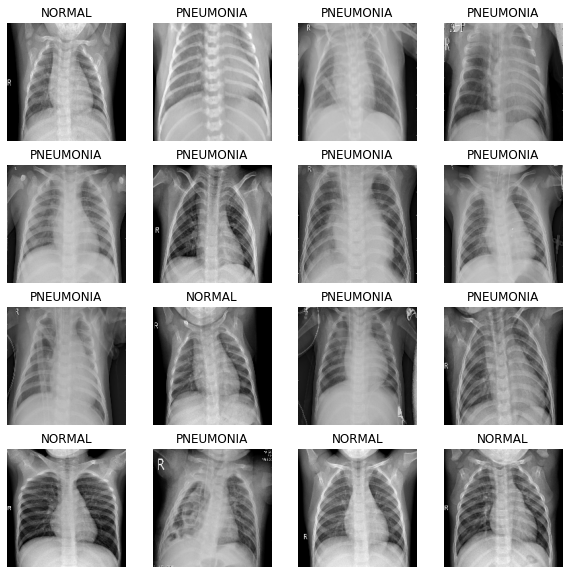

In [39]:
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch, label_batch)

### Modeling

In [55]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
    ])
    
    return block

In [56]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [57]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

- Batch Normalization Layer 를 모두 삭제하고, dropout 만을 사용할 수 있도록 모델을 수정해주었습니다.

### Weight Balancing

In [58]:
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


### Training

In [59]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [60]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 58s 189ms/step - loss: 0.6941 - accuracy: 0.5010 - precision: 0.7424 - recall: 0.5039 - val_loss: 0.6843 - val_accuracy: 0.7385 - val_precision: 0.7385 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 48s 183ms/step - loss: 0.6938 - accuracy: 0.5129 - precision: 0.7431 - recall: 0.5272 - val_loss: 0.7027 - val_accuracy: 0.2644 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
261/261 [==============================] - 48s 185ms/step - loss: 0.6937 - accuracy: 0.4782 - precision: 0.7491 - recall: 0.4488 - val_loss: 0.6924 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 48s 186ms/step - loss: 0.6935 - accuracy: 0.5876 - precision: 0.7447 - recall: 0.6780 - val_loss: 0.6981 - val_accuracy: 0.2644 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
261/261 [==============================] - 50s 191ms/step - loss:

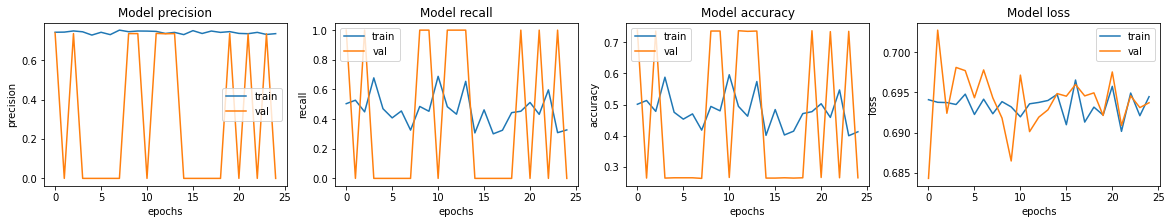

In [61]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### Evaluate

In [62]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 109ms/step - loss: 0.6935 - accuracy: 0.3750 - precision: 0.0000e+00 - recall: 0.0000e+00
Loss: 0.6934524774551392,
Accuracy: 0.375,
Precision: 0.0,
Recall: 0.0


- 그래프를 보면, 학습이 정상적으로 진행되지 않음을 알 수 있습니다.
- Precision 과 Recall 도 0.0 으로 도출되었습니다.
- 이는 Batch Normalization 이 없어 입력 데이터에 대한 정규화가 수행되지 않고, scaling 과 shifting 또한 수행되지 않아 학습이 진행되지 못한 것으로 보입니다.
- 따라서, 이번 프로젝트에서는 Batch Normalization 과 Dropout 을 함께 사용하도록 하겠습니다.

# Source Code 1.4)

- 1.4) 에서는 초기에 설정해주었던 Batch size 와 Epoch 을 변경해보도록 하겠습니다.

### Load Data

In [67]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

IMAGE_SIZE = [180, 180]

ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

BATCH_SIZE = 32
EPOCHS = 15

print(ROOT_PATH)

/aiffel/aiffel


- batch size 를 2 배인 32 로 늘리고, epoch 를 25 에서 15 로 줄여주었습니다.

In [68]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [69]:
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

train_size = math.floor(len(filenames) * 0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [70]:
COUNT_NORMAL = len([filename for filename in train_filenames if 'NORMAL' in filename])
print("Normal images count in training set: {}".format(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if 'PNEUMONIA' in filename])
print("Pneumonia images count in training set: {}".format(COUNT_PNEUMONIA))

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [71]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [72]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: {}".format(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: {}".format(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


### Data Preprocessing

In [73]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [74]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [75]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [76]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### Data Visualization

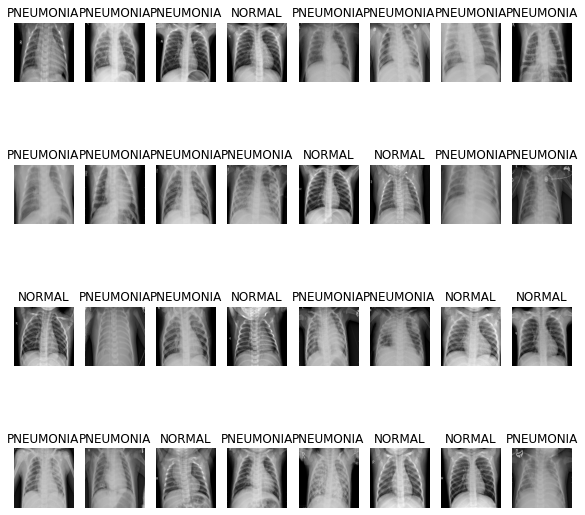

In [77]:
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch, label_batch)

- 라벨링이 성공적으로 수행되었으며, batch size 도 32 로 늘어난 것을 확인하였습니다.

### Modeling

In [80]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [81]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [82]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### Weight Balancing

In [83]:
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


### Training

In [84]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [85]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/15
130/130 [==============================] - 58s 370ms/step - loss: 0.3618 - accuracy: 0.8416 - precision: 0.9621 - recall: 0.8194 - val_loss: 0.6900 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 2/15
130/130 [==============================] - 48s 367ms/step - loss: 0.2017 - accuracy: 0.9264 - precision: 0.9771 - recall: 0.9228 - val_loss: 0.8673 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 3/15
130/130 [==============================] - 47s 366ms/step - loss: 0.1749 - accuracy: 0.9377 - precision: 0.9790 - recall: 0.9362 - val_loss: 1.0883 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 4/15
130/130 [==============================] - 48s 374ms/step - loss: 0.1493 - accuracy: 0.9495 - precision: 0.9842 - recall: 0.9474 - val_loss: 1.5555 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 5/15
130/130 [==============================] - 49s 382ms/step - loss: 0.1232 - accura

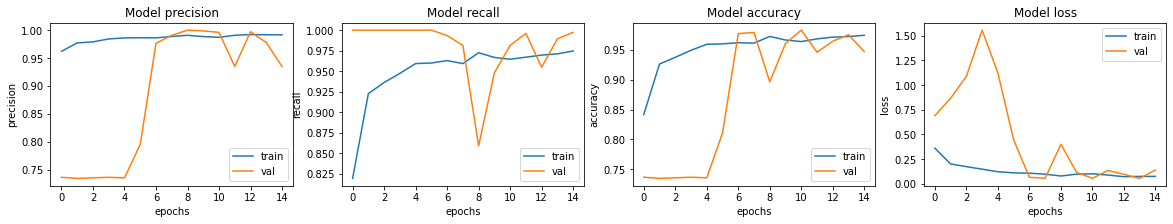

In [86]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

- accuracy 는 증가, loss 는 감소하는 그래프로서, 학습이 정상적으로 진행되었음을 알 수 있습니다.
- 그래프 초기에 학습이 진행되지 않고 일정한 추이를 보이는 이유는 가중치의 초기값 설정이 잘못되었기 때문이라고 생각했습니다.
- 하지만, 이후 다시 정상적인 학습 사이클로 수행되었음을 알 수 있습니다.

### Evaluate

In [87]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 4s 199ms/step - loss: 1.5105 - accuracy: 0.6875 - precision: 0.6667 - recall: 1.0000
Loss: 1.5104697942733765,
Accuracy: 0.6875,
Precision: 0.6666666865348816,
Recall: 1.0


- Accuracy 는 0.68 로 하락하였습니다.
- batch size 를 늘려 가중치를 업데이트할 때 한 번에 학습하는 데이터의 양을 늘려주었으나, epoch 또한 감소하면서, 학습이 미숙하게 진행되었을 가능성을 의심하였습니다.

# Source Code 1.5)

- 1.5) 에서는 앞선 1.4) 의 batch size 인 32 를 그대로 사용하는 대신, epoch 를 25 로 늘려 학습을 다시 진행해보겠습니다.

### Load Data

In [88]:
print(train_ds)
print(val_ds)
print(test_ds)

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>
<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>
<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>


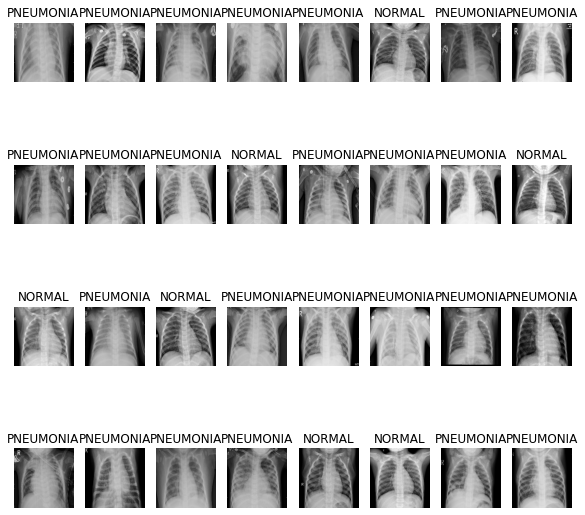

In [89]:
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch, label_batch)

### Modeling

In [90]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [91]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [92]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### Weight Balancing

In [93]:
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


### Training

In [94]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [95]:
EPOCHS = 25

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
130/130 [==============================] - 58s 379ms/step - loss: 0.3969 - accuracy: 0.8005 - precision: 0.9535 - recall: 0.7692 - val_loss: 0.5837 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 2/25
130/130 [==============================] - 48s 367ms/step - loss: 0.2063 - accuracy: 0.9231 - precision: 0.9786 - recall: 0.9166 - val_loss: 0.7487 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 3/25
130/130 [==============================] - 47s 366ms/step - loss: 0.1622 - accuracy: 0.9394 - precision: 0.9817 - recall: 0.9360 - val_loss: 0.8910 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 4/25
130/130 [==============================] - 49s 375ms/step - loss: 0.1372 - accuracy: 0.9490 - precision: 0.9839 - recall: 0.9469 - val_loss: 1.0968 - val_accuracy: 0.7373 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 5/25
130/130 [==============================] - 50s 386ms/step - loss: 0.1354 - accura

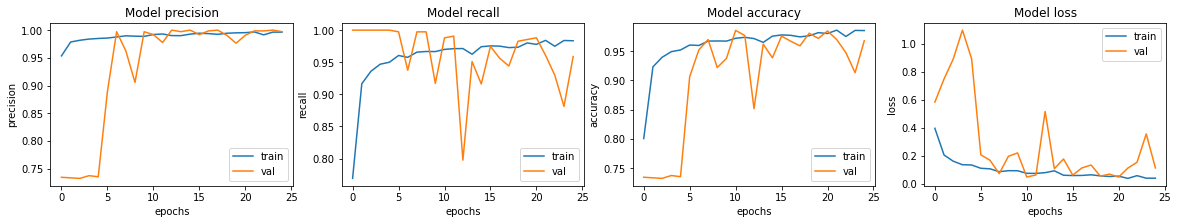

In [96]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### Evaluate

In [97]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 4s 199ms/step - loss: 0.8813 - accuracy: 0.8237 - precision: 0.7881 - recall: 0.9821
Loss: 0.8813458681106567,
Accuracy: 0.8237179517745972,
Precision: 0.7880658507347107,
Recall: 0.9820512533187866


- epoch 를 25 회로 늘린 후 Accuracy 가 0.82 로 증가하였습니다.
- Recall 또한 0.98 로 준수한 성능을 보여주고 있습니다.
- 이로써, 1.4) 에서는 Batch size 를 늘리고 epoch 를 줄이면서 학습이 미숙하게 진행되어 낮은 Accuracy 가 도출되었음을 간접적으로 확인하였습니다.

# Source Code 1.6)

- 이번에는 dropout 과 filter 의 하이퍼 파라미터의 변경을 시도해보겠습니다.
- 데이터의 Batch size 는 다시 16 으로 조정해주겠습니다.

### Load Data

In [98]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

IMAGE_SIZE = [180, 180]

ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


In [99]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

In [100]:
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

train_size = math.floor(len(filenames) * 0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [101]:
COUNT_NORMAL = len([filename for filename in train_filenames if 'NORMAL' in filename])
print("Normal images count in training set: {}".format(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if 'PNEUMONIA' in filename])
print("Pneumonia images count in training set: {}".format(COUNT_PNEUMONIA))

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [102]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: {}".format(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: {}".format(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


### Data Preprocessing

In [103]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [104]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [105]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [106]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### Data Visualization

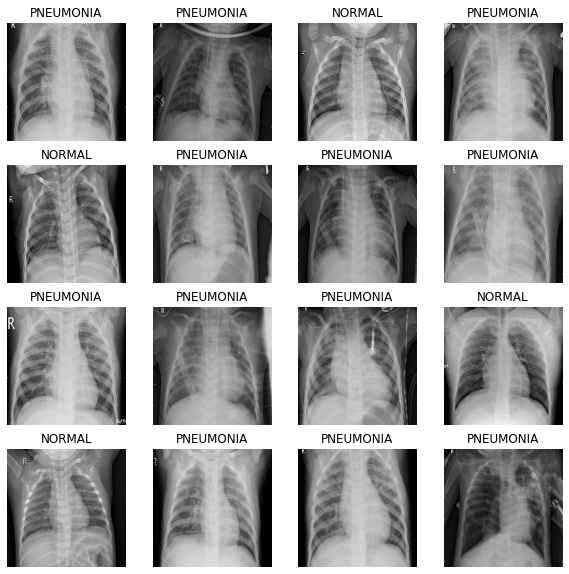

In [107]:
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch, label_batch)

### Modeling

In [113]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [114]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [115]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(64),
        conv_block(128),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.3),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.6),
        dense_block(128, 0.6),
        dense_block(64, 0.5),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

- 전체적인 필터의 크기를 늘려주면서, 과적합을 방지하기 위해 dropout 비율을 높였습니다.

### Weight Balancing

In [116]:
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


### Training

In [117]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [118]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 60s 192ms/step - loss: 0.6181 - accuracy: 0.6753 - precision: 0.8907 - recall: 0.6425 - val_loss: 0.5869 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 50s 190ms/step - loss: 0.3112 - accuracy: 0.8654 - precision: 0.9636 - recall: 0.8513 - val_loss: 0.8299 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 50s 190ms/step - loss: 0.2390 - accuracy: 0.9083 - precision: 0.9703 - recall: 0.9044 - val_loss: 0.6790 - val_accuracy: 0.7356 - val_precision: 0.7353 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 50s 192ms/step - loss: 0.1990 - accuracy: 0.9239 - precision: 0.9738 - recall: 0.9224 - val_loss: 0.1405 - val_accuracy: 0.9404 - val_precision: 0.9292 - val_recall: 0.9948
Epoch 5/25
261/261 [==============================] - 52s 199ms/step - loss: 0.1587 - accura

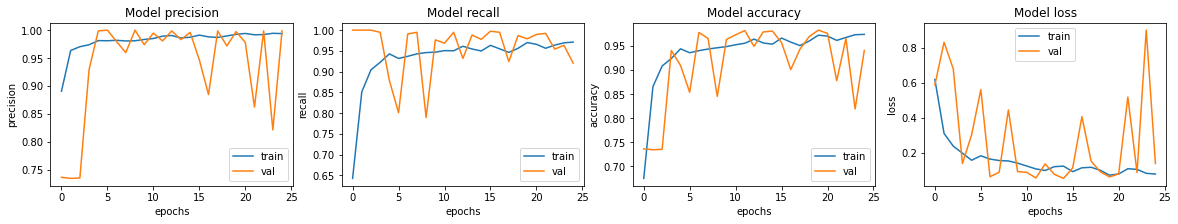

In [119]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

- 그래프를 보면, accuracy 는 증가, loss 는 감소하고 있지만 학습이 불안정한 문제가 발생하고 있습니다.
- 이를 해결하기 위해 batch size 를 늘리는 방법을 채택할 수 있습니다.

### Evaluate

In [120]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 107ms/step - loss: 0.4480 - accuracy: 0.8878 - precision: 0.8636 - recall: 0.9744
Loss: 0.44799745082855225,
Accuracy: 0.8878205418586731,
Precision: 0.8636363744735718,
Recall: 0.9743589758872986


- testing data 에 대한 accuracy 는 약 0.89 로 높은 수치를 보여주었습니다.
- 결과적으로 data augmentation 을 사용하지 않으면서도 filter 의 크기를 늘리고, dropout 의 비율을 높여줌으로서, 루브릭 기준인 0.85 를 넘는 기록을 달성하였습니다.
- 중요한 지표인 Recall 또한 0.97 로 높은 성능이 도출되었습니다.

# Source Code 1.7)

- 1.7) 에서는 앞선 1.6) 에서의 문제였던 학습의 불안정성을 잡아보기 위해 Batch size 를 늘려 학습시키는 시도를 해보겠습니다.
- Batch Normalization 과 dropout 을 함께 사용할 것이므로, 과적합에 대한 걱정없이 epoch 를 30 으로 늘려 학습을 진행시켜보겠습니다.

### Load Data

In [129]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

IMAGE_SIZE = [180, 180]

ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

BATCH_SIZE = 32
EPOCHS = 30

print(ROOT_PATH)

/aiffel/aiffel


In [130]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

In [131]:
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

train_size = math.floor(len(filenames) * 0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [132]:
COUNT_NORMAL = len([filename for filename in train_filenames if 'NORMAL' in filename])
print("Normal images count in training set: {}".format(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if 'PNEUMONIA' in filename])
print("Pneumonia images count in training set: {}".format(COUNT_PNEUMONIA))

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [133]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: {}".format(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: {}".format(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


### Data Preprocessing

In [134]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [135]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [136]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [137]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### Data Visualization

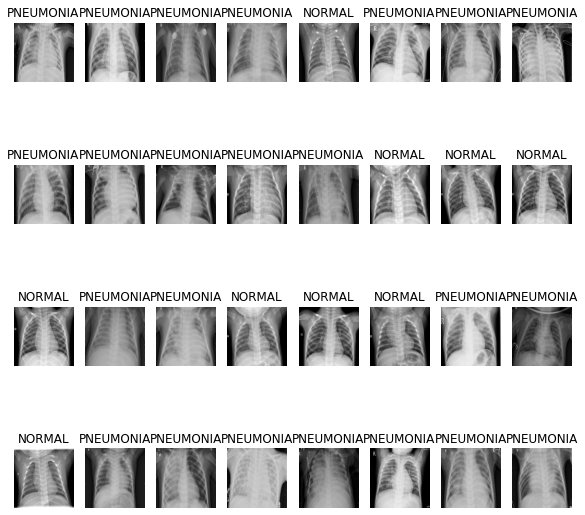

In [138]:
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch, label_batch)

### Modeling

In [139]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [140]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [141]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(64),
        conv_block(128),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.3),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.6),
        dense_block(128, 0.6),
        dense_block(64, 0.5),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### Weight Balancing

In [142]:
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


### Training

In [143]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [144]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/30
130/130 [==============================] - 59s 374ms/step - loss: 0.6421 - accuracy: 0.6637 - precision: 0.8822 - recall: 0.6320 - val_loss: 0.5964 - val_accuracy: 0.7373 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 2/30
130/130 [==============================] - 49s 376ms/step - loss: 0.2682 - accuracy: 0.8820 - precision: 0.9738 - recall: 0.8646 - val_loss: 0.6715 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 3/30
130/130 [==============================] - 49s 381ms/step - loss: 0.1868 - accuracy: 0.9334 - precision: 0.9793 - recall: 0.9303 - val_loss: 0.8812 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 4/30
130/130 [==============================] - 50s 385ms/step - loss: 0.1615 - accuracy: 0.9430 - precision: 0.9792 - recall: 0.9433 - val_loss: 1.1845 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 5/30
130/130 [==============================] - 51s 392ms/step - loss: 0.1351 - accura

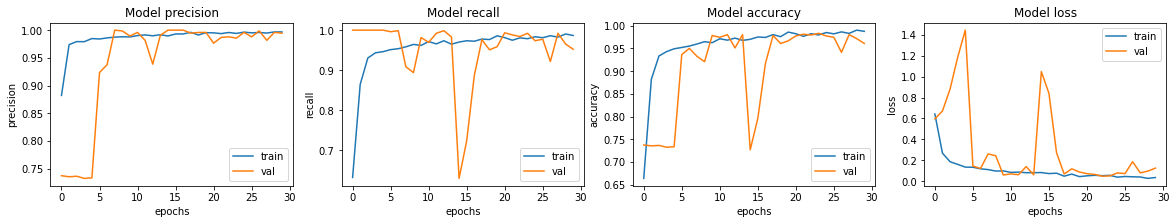

In [145]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

- batch size 를 늘려줌으로서, 그래프의 변동이 이전보다 확연히 줄어들고 학습이 비교적 안정성있게 진행되었음을 알 수 있습니다.
- epoch 진행 중 validation 의 accuracy 와 loss 가 높게 튄 현상은 mini batch 의 데이터 분포 차이로 인해 생긴 것으로 일시적인 현상이라 판단했습니다.

### Evaluate

In [146]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 5s 222ms/step - loss: 1.1630 - accuracy: 0.8013 - precision: 0.7639 - recall: 0.9872
Loss: 1.163040280342102,
Accuracy: 0.8012820482254028,
Precision: 0.7638888955116272,
Recall: 0.9871794581413269


- batch size 와 epoch 를 늘려 학습한 모델을 testing data 로 평가해보았습니다.
- 이전과 비교하여 Accuracy 는 0.80 으로 오히려 떨어진 양상을 보이고 있습니다.
- 이는 마지막 epoch 의 training set 에서 accuracy 가 약 0.99 로 과적합을 의심해볼 수 있었습니다.
- 따라서, 다음은 epoch 를 25 로 낮추고, dropout 비율을 조금씩 높여 학습을 진행해보겠습니다.

# Source Code 1.8)

- 1.7) 에서 training set 에 대한 accuracy 가 높았고 testing set 에 대한 accuracy 가 낮게 나왔으므로 과적합을 의심해보았습니다.
- 이를 확인하기 위해 epoch 를 줄이고 dropout 비율을 0.1 씩 높여 학습을 진행해보도록 하겠습니다.

### Load Data

In [154]:
print(train_ds)
print(val_ds)
print(test_ds)

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>
<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>
<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>


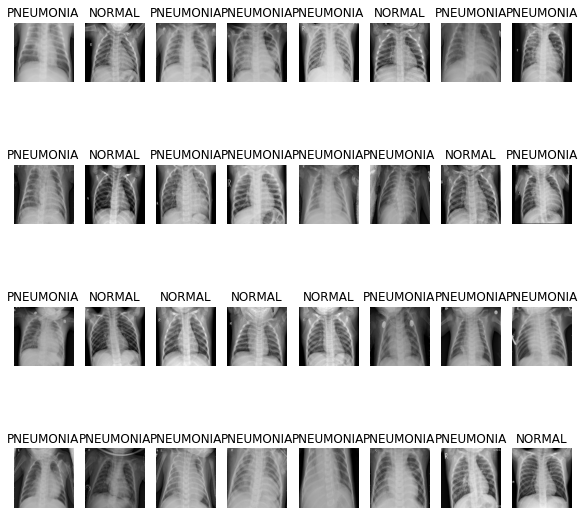

In [148]:
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch, label_batch)

### Modeling

In [155]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [156]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [157]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(64),
        conv_block(128),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.4),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.7),
        dense_block(64, 0.6),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### Weight Balancing

In [158]:
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


### Training

In [159]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [160]:
EPOCHS = 25

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
130/130 [==============================] - 59s 387ms/step - loss: 0.9429 - accuracy: 0.5382 - precision: 0.7841 - recall: 0.5226 - val_loss: 0.6903 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 2/25
130/130 [==============================] - 48s 374ms/step - loss: 0.4740 - accuracy: 0.7529 - precision: 0.9414 - recall: 0.7118 - val_loss: 0.5891 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 3/25
130/130 [==============================] - 49s 379ms/step - loss: 0.2664 - accuracy: 0.8834 - precision: 0.9791 - recall: 0.8618 - val_loss: 0.7663 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 4/25
130/130 [==============================] - 49s 378ms/step - loss: 0.2341 - accuracy: 0.9087 - precision: 0.9754 - recall: 0.8995 - val_loss: 1.1115 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 5/25
130/130 [==============================] - 51s 395ms/step - loss: 0.2039 - accura

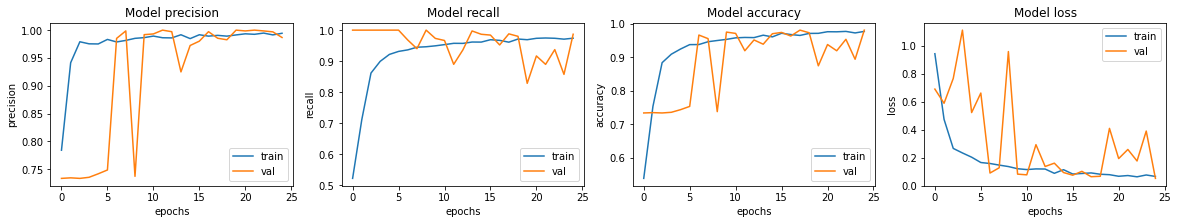

In [161]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### Evaluate

In [162]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 4s 198ms/step - loss: 1.1605 - accuracy: 0.7372 - precision: 0.7040 - recall: 1.0000
Loss: 1.1604628562927246,
Accuracy: 0.7371794581413269,
Precision: 0.7039711475372314,
Recall: 1.0


- Accuracy 는 0.74 가 도출되었습니다.
- 1.7) 과 비교하여 epoch 를 줄이고 dropout 비율을 높이면서 과적합에 대한 방지를 해주었지만 Accuracy 는 오히려 하락하였습니다.
- Recall 이 1 이 나왔다는 점에서 학습의 정상적인 수행을 의심할 수 있었습니다.
- 실제로, 우리가 가진 training set 에서는 폐렴 양성 이미지의 수가 절대적으로 많습니다.
- 따라서, Precision 이 0.70 으로 하락하고, Recall 이 오르면서, 전체적인 Accuracy 가 낮아졌다는 것은 모델의 성능이 굉장히 좋지 않다는 것을 의미합니다.
- 양성 이미지의 수가 정상 이미지의 수보다 약 3 배가량 많으므로, 모든 데이터에 대해 양성으로 예측하더라도 0.75 의 Accuracy 가 나와줄 것이기 때문입니다.
- 심지어 이 모델은 Recall 이 1 이 나왔으므로 대부분의 데이터에 대해 양성으로 예측했음을 알 수 있습니다.